In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .

In [ ]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertModel,
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

%run utils_fake_news.py

## Preprocess & Encode Data

In [ ]:
# Load the LIAR dataset
df_train = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/liar_train.tsv", sep='\t', header=None)
df_test = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/liar_test.tsv", sep='\t', header=None)
df_valid = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/liar_valid.tsv", sep='\t', header=None)

# Relabel columns
cols = ['ID', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state',
       'party', 'barely_true_count', 'false_count', 'half_true_count',
       'mostly_true_count', 'pants_on_fire_count', 'context']
df_train.columns, df_test.columns, df_valid.columns = cols, cols, cols

# Relabel target
df_train['target'] = df_train['label'].apply(lambda x: label_encodings2[x])
df_test['target'] = df_test['label'].apply(lambda x: label_encodings2[x])
df_valid['target'] = df_valid['label'].apply(lambda x: label_encodings2[x])

# Encode dataframes
df_train_encode = encode_dataframe(df_train['statement'], df_train['target'])
df_test_encode = encode_dataframe(df_test['statement'], df_test['target'])
df_valid_encode = encode_dataframe(df_valid['statement'], df_valid['target'])

# Save
torch.save(df_train_encode,
           "/content/drive/MyDrive/fake-news-explainability/Data/liar_encoded_train_2class.pt")
torch.save(df_test_encode,
           "/content/drive/MyDrive/fake-news-explainability/Data/liar_encoded_test_2class.pt")
torch.save(df_valid_encode,
           "/content/drive/MyDrive/fake-news-explainability/Data/liar_encoded_valid_2class.pt")

## Model & Training Function

In [ ]:
def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

            # Unpack batch
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output = bert_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            # Accumulate loss
            total_train_loss += output[0].item()

            # Backward pass
            output[0].backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        
        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Time': training_time,
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [ ]:
# Run if the data has already been encoded
# Load encoded LIAR dataset
df_train_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/liar/training/liar_encoded_train_2class.pt")
df_test_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/liar/training/liar_encoded_test_2class.pt")

In [ ]:
# Load data into dataloader
batch_size = 32

bert_train_dataloader = DataLoader(
            df_train_encode,  # The training samples.
            sampler = RandomSampler(df_train_encode), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
bert_validation_dataloader = DataLoader(
            df_test_encode, # The validation samples.
            sampler = SequentialSampler(df_test_encode), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Training

In [ ]:
# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

# BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           num_labels = 2,
                                                           output_attentions = False,
                                                           output_hidden_states = False
                                                          ).to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Training Params
bert_training_stats = []
epochs = 2
total_steps = len(bert_train_dataloader) * epochs

# Learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Train
train()

======== Epoch 1 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:26.
  Batch    80  of    320.    Elapsed: 0:00:53.
  Batch   120  of    320.    Elapsed: 0:01:19.
  Batch   160  of    320.    Elapsed: 0:01:45.
  Batch   200  of    320.    Elapsed: 0:02:11.
  Batch   240  of    320.    Elapsed: 0:02:37.
  Batch   280  of    320.    Elapsed: 0:03:03.

  Average training loss: 0.64
  Training epoch took: 0:03:29
======== Epoch 2 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:26.
  Batch    80  of    320.    Elapsed: 0:00:52.
  Batch   120  of    320.    Elapsed: 0:01:18.
  Batch   160  of    320.    Elapsed: 0:01:44.
  Batch   200  of    320.    Elapsed: 0:02:10.
  Batch   240  of    320.    Elapsed: 0:02:36.
  Batch   280  of    320.    Elapsed: 0:03:02.

  Average training loss: 0.58
  Training epoch took: 0:03:28

Training complete!
Total training took 0:06:56 (h:mm:ss)


In [ ]:
# Save model
bert_model.save_pretrained("/content/drive/MyDrive/fake-news-explainability/Models/bert_model_2class")

## Evaluate

In [ ]:
# Load model if has been trained
bert_model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/fake-news-explainability/Models/bert_model_2class",
    num_labels = 2
    ).to(device)

In [ ]:
# Load encoded tensors
df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/liar/evaluation/liar_encoded_valid_pos_2class.pt")
df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/Data/Encoded/liar/evaluation/liar_encoded_valid_neg_2class.pt")

In [ ]:
# Generate predictions
with torch.no_grad():
    outputs_pos = bert_model(df_pos_encode.tensors[0].to(device),
                              token_type_ids=None, 
                              attention_mask=df_pos_encode.tensors[1].to(device),
                              labels=df_pos_encode.tensors[2].to(device))
    outputs_neg = bert_model(df_neg_encode.tensors[0].to(device),
                               token_type_ids=None, 
                               attention_mask=df_neg_encode.tensors[1].to(device),
                               labels=df_neg_encode.tensors[2].to(device))
    
# Positive statement accuracy
print(f"Test Acc: {flat_accuracy(outputs_pos[1].detach().cpu().numpy(), df_pos_encode.tensors[2].to('cpu').numpy())}")

# Negative statement accuracy
print(f"Valid Acc: {flat_accuracy(outputs_neg[1].detach().cpu().numpy(), df_neg_encode.tensors[2].to('cpu').numpy())}")

Test Acc: 0.6899383983572895
Valid Acc: 0.6735112936344969


## Negation

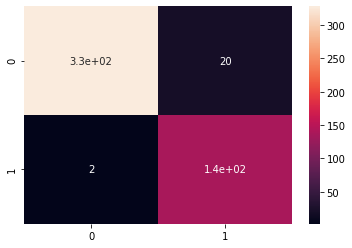

In [ ]:
# Confusion matrix
cf_matrix = confusion_matrix(torch.argmax(outputs_pos[1].cpu(), axis=1), 
                             torch.argmax(outputs_neg[1].cpu(), axis=1))
sns.heatmap(cf_matrix, annot=True)